In [1]:
import sys
import os
from datetime import datetime
#module_dir = os.path.expanduser("/Users/jessedejong/buy-bay/model/")
module_dir = os.path.dirname(os.getcwd())
sys.path.append(module_dir)

import src.format as src_format
import src.csv_loader as loader

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import xgboost as xgb
pd.options.mode.chained_assignment = None  # to prevent chained assignment warnings that are not relevant

import math
import scipy as sp

## required for db writing and reading
import sqlite3
from pandas.io import sql # and reading (opt)
#import pymysql
#import pymysql.cursors

import logging
import time
import timeit

## data science pipeline tools
from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.datasets import dump_svmlight_file, load_svmlight_file
from sklearn import preprocessing

from sklearn.externals import joblib

import random

#plotting
import pylab as pl
import matplotlib.pyplot as plt

## to make pipeline work with pandas column input 
from sklearn_pandas import DataFrameMapper
projdir = '../data/'

In [3]:
#Load csv files
categories_df = loader.load_csv(projdir + 'category_mappings.csv', format=False)
data_df = loader.load_csv(projdir + 'xgb_data.csv')

b'Skipping line 823768: expected 12 fields, saw 16\nSkipping line 823769: expected 12 fields, saw 16\nSkipping line 823770: expected 12 fields, saw 16\nSkipping line 823771: expected 12 fields, saw 16\nSkipping line 823772: expected 12 fields, saw 16\nSkipping line 823773: expected 12 fields, saw 16\nSkipping line 823774: expected 12 fields, saw 16\nSkipping line 823775: expected 12 fields, saw 16\nSkipping line 823776: expected 12 fields, saw 16\nSkipping line 823777: expected 12 fields, saw 16\nSkipping line 823778: expected 12 fields, saw 16\n'
b'Skipping line 1017798: expected 12 fields, saw 13\nSkipping line 1017799: expected 12 fields, saw 13\nSkipping line 1017800: expected 12 fields, saw 13\nSkipping line 1017801: expected 12 fields, saw 13\nSkipping line 1017802: expected 12 fields, saw 13\nSkipping line 1017803: expected 12 fields, saw 13\nSkipping line 1017804: expected 12 fields, saw 13\nSkipping line 1017805: expected 12 fields, saw 13\nSkipping line 1017806: expected 12 f

In [4]:
#Merge product id's with category Mappings
categories_df = pd.DataFrame(categories_df.groupby(['category_id'])['mapped_category_id'].apply(list)).reset_index()
merged_df = pd.merge(data_df, categories_df, how='left', left_on='internal_category_id', right_on='category_id')

#Give correct types
merged_df['mapped_category_id'] = merged_df['mapped_category_id'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
merged_df['created_at'] = pd.to_datetime(merged_df['created_at']).dt.date
merged_df['product_id'] = merged_df['product_id'].apply(int)
merged_df['ref_new_price'] = merged_df['ref_new_price'].apply(float)

# Filter on raw data

In [5]:
# Filter Duplicates 
merged_df.sort_values(by=['product_id', 'created_at', 'ref_new_price'], ascending=[True, True, True])
merged_df = merged_df.drop_duplicates(subset=['product_id', 'created_at'], keep='first').reset_index(drop = True)

# Drop Hitmeister and fonq as competitors
merged_df = merged_df[merged_df['competitor']!='Hitmeister']
merged_df = merged_df[merged_df['competitor']!='Fonq']

# Drop competitors with low number of ref_prices

competitor_count = pd.pivot_table(merged_df, index='competitor', values=['product_id'], aggfunc=len)
competitor_count = competitor_count.unstack().reset_index().drop('level_0', axis=1)
competitor_count = competitor_count[competitor_count[0]>1000]
merged_df = merged_df[merged_df['competitor'].isin(competitor_count['competitor'])]

# Drop duplicates (products and dates)

In [6]:
#Filter Duplicates 
merged_df.sort_values(by=['product_id', 'created_at', 'ref_new_price'], ascending=[True, True, True])
price_df = merged_df.drop_duplicates(subset=['product_id', 'created_at'], keep='first').reset_index(drop = True)

# Filter products

In [7]:
# Filters all products with low number of prices
pricedates_per_product = pd.pivot_table(price_df, index='product_id', values=['ref_new_price'], aggfunc=len)
pricedates_per_product = pricedates_per_product.unstack().reset_index().drop('level_0', axis=1)
pricedates_per_product = pricedates_per_product[pricedates_per_product[0] >= 30]

price_df = price_df[price_df['product_id'].isin(pricedates_per_product['product_id'])]

# TODO: Filter Gaps

# Add columns


In [8]:
# Add first found price_date and first found ref_price
first_price = price_df.sort_values(['product_id', 'created_at']).drop_duplicates('product_id', keep = 'first').reset_index(drop = True)
first_price = first_price[['product_id', 'created_at', 'ref_new_price']]
first_price.rename(columns={'created_at': 'first_date', 'ref_new_price':'first_price'}, inplace=True)
price_track = price_df.merge(first_price, on='product_id').sort_values(['product_id', 'created_at']).reset_index(drop = True)

# Adds till from first found price 
price_track['days_from_first'] = price_track['created_at'] - price_track['first_date']
price_track['days_from_first'] = price_track['days_from_first'].dt.days

# Adds the percentage of first found price
price_track['perc_of_price'] = price_track['ref_new_price']/price_track['first_price'].apply(float)

# To satisfy naming convention
price_track['days_ago'] = price_track['days_from_first']

# Plot Data

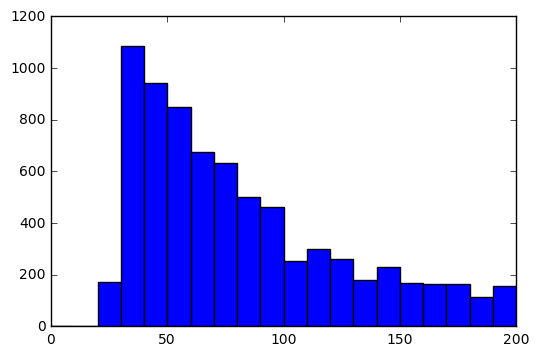

In [9]:
first_price['first_price'].hist(grid = False, bins=20, range=[0,200])

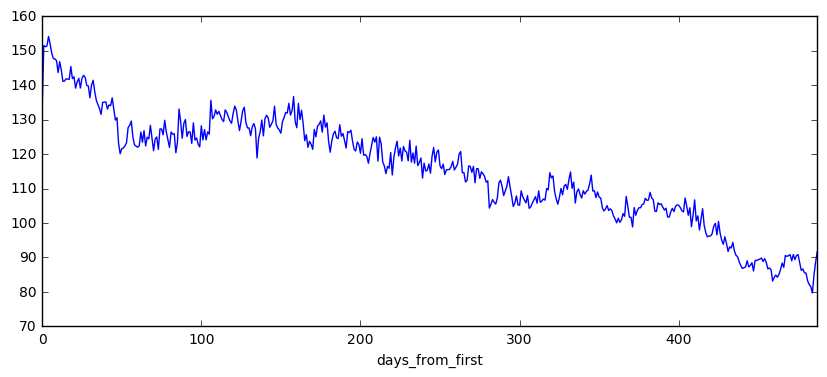

In [10]:
price_track_avg = price_track.groupby('days_from_first')['ref_new_price'].mean()
ax = price_track_avg.plot(figsize = (10,4))

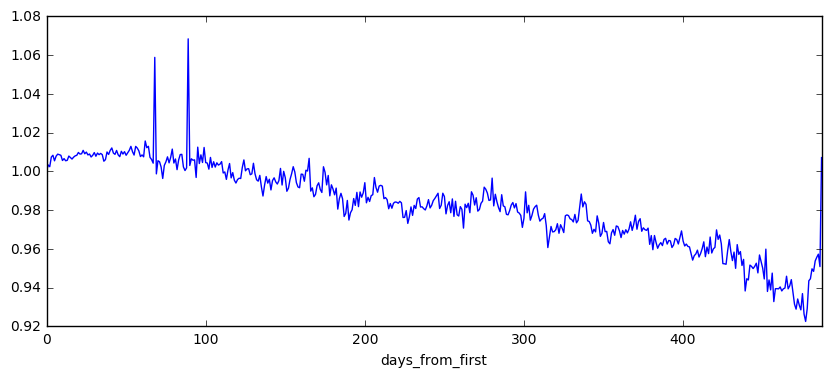

In [11]:
price_track_perc = price_track.groupby('days_from_first')['perc_of_price'].mean()
price_track_perc.plot(figsize = (10,4))

# Sort/Group data

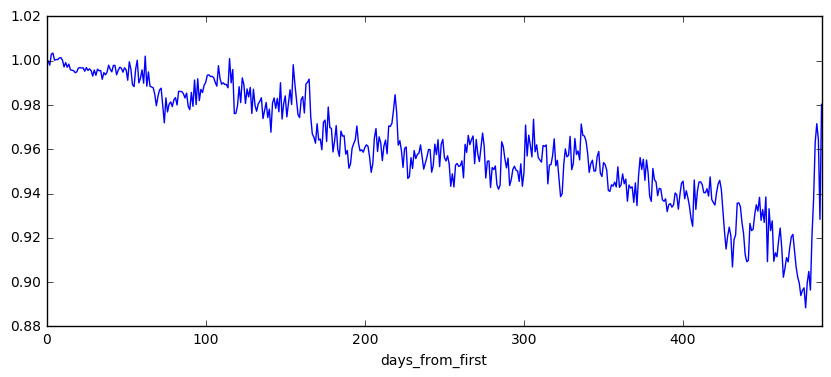

In [12]:
price_track_low_ref_price = price_track[price_track['first_price']>100]
price_track_plot = price_track_low_ref_price.groupby('days_from_first')['perc_of_price'].mean()
price_track_plot.plot(figsize = (10,4))

# Remove gaps

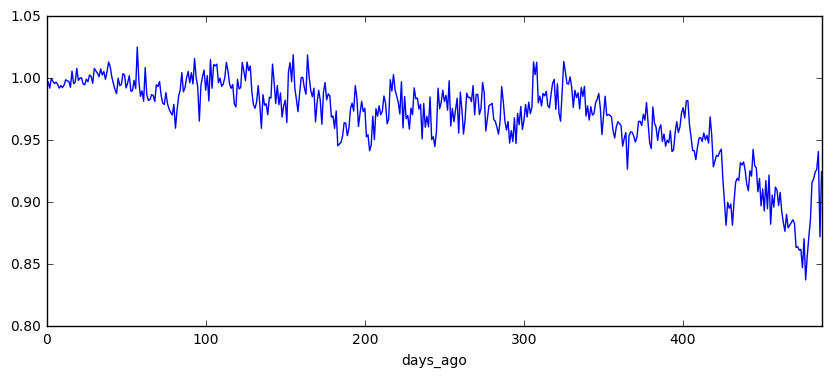

In [13]:
price_track_copy = price_track_low_ref_price.drop('first_date', axis=1)
price_track_copy = src_format.rm_gaps(price_track_copy, gap_size=30)
no_gap_plot = price_track_copy.groupby('days_ago')['perc_of_price'].mean()
no_gap_plot.plot(figsize = (10,4), kind='line')

# Make data stationary

In [28]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

ImportError: cannot import name 'TimeSeries'

In [25]:
sqrt_price_track = price_track_copy.copy()
sqrt_price_track.loc[:, 'perc_of_price'] = sqrt_price_track.perc_of_price.apply(np.cbrt)
sqrt_plot = sqrt_price_track.groupby('days_ago')['perc_of_price'].mean()
test_stationarity(sqrt_plot)

NameError: name 'test_stationarity' is not defined